# InstaSpot

Our main goal is to be able to recommend new travel destinations to users based on their interest in travel posts on Instagram. To achieve this, we will explore different ways to build recommender systems. We will compare results between a content-based and a matrix factorization based collaborative filtering approach.

## Table of Content

1. Importing modules
    * Initialize spark session
    * Define metadata
2. Data processing
    * Retrieve travel influencers  
    * Extract travel post metadata
    * Extract relevant fields
    * Create dataframe
3. Data Analysis
    * Location
    * Instagram users
    * Hashtags
    * Caption
    * Accessibility caption
4. Content-Based Recommendation
    * Model 1
    * Model 2
    * Bonus
5. Latent Factor Models
    * Model 1
    * Model 2
    * Model 3
    * Model 4
    * Model 5
    * Model performances on test set
    * Top 5 recommendation for a specific user

## 1. Importing modules

First, let's import some libraries that we're going to use in the notebook.

In [1]:
import os
import re
import csv
import shutil
import difflib
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import sum
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.functions import count
from pyspark.sql.functions import explode
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
warnings.filterwarnings("ignore")

Let's also initialize our spark session

In [2]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.ui.showConsoleProgress", 'false') \
        .getOrCreate()
    return spark

In [3]:
spark = init_spark()
spark.sparkContext.setLogLevel("OFF")

22/04/10 16:22:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Let's define some metadata

In [4]:
# To modify accordingly
INFO_PATH = 'data/info/'
POST_PATH = 'data/post-metadata/'
DATASET_PATH = 'data/post-metadata/*.info'
INFLUENCER_TEXT_PATH = 'data/influencers.txt'
SEED = 123

## 2. Data processing

Our [dataset](https://sites.google.com/site/sbkimcv/dataset#h.4eo4r5p70z10) comes from Proceedings of The Web Conference (WWW 20), ACM, 2020, provided by Seungbae Kim.

This dataset classified influencers into nine categories namely *beauty, family, fashion, fitness, food, interior, pet, travel, and others*. It contains 300 posts per influencer, so there are over 10 million Instagram posts where each influencer is categorized based on their post metadata. Each post metadata file is in JSON format.

### Retrieve travel influencers


Since we're only interested in travel influencers, we will retrieve all usernames from the travel category using <code>influencers.txt</code> which contains a list of influencers with their Instagram username, category, the number of followers, followees, and posts.

In [5]:
lines = spark.sparkContext.textFile(INFLUENCER_TEXT_PATH)

# get category and username index
headers = lines.take(2)
header = headers[0]
category_index = header.split("\t").index("Category")
username_index = header.split("\t").index("Username")
post_index = header.split("\t").index("#Posts")

# filter travel influencers
lines = lines.filter(lambda line: line not in headers)
lines = lines.map(lambda line: line.split("\t"))
travel_influencers = lines.filter(lambda line: line[category_index] == 'travel')
# get all travel influencers IG username
travel_usernames = travel_influencers.map(lambda line: line[username_index])

print('Total travel users:',travel_usernames.count())

Total travel users: 4210


As we can see above, there were 4210 instagram users categorized as travel influencers. 

### Extract travel post metadata 
Now let's go ahead and extract the post metadata of those users only. Each post metadata filename starts with a username followed by a post ID. 

In [6]:
# file_list = os.listdir(INFO_PATH)

# for name in travel_usernames.collect():
#     st = f'.{name}..info$'
#     p = re.compile(st, re.IGNORECASE)
#     for f in file_list:
#         if p.match(f):
#             shutil.copy(f'{INFO_PATH}{f}', POST_PATH)

### Extract relevant fields
Since there are more information than we need, we will extract relevant fields from the JSON files.

The following fields are the ones we found the most relevant to our project:

| Fields               | Description                                      |
| :------------------- | :------------------------------------------------|
| post_id              | ID of the instagram post                         |
| owner_id             | owner id of instagram post                       |
| owner_username       | owner username of instagram post                 |
|accessibility_caption | describes what the post is about                 |
|likes_count           | number of likes the post received                |
|comments_count        | number of comments the post received             |
|commenters_id         | ID list of users who commented on the post       |
|commenters_username   | username list of users who commented on the post |
|tagged_users_id       | ID list of tagged users on the post              |
|tagged_users_username | username list of tagged users on the post        |
|caption               | caption of the post                              |
|hashtags              | hashtags from caption of the post                |
|location_id           | location id of the post                          |
|location_name         | location name of the post                        |

### Helper functions

Below are helper functions that will extract the required fields.

In [5]:
# helper function to extract counts
def extract_counts(row, field):
    if field not in row:
        return 0
    if row[field] is None:
        return 0
    if 'count' not in row[field] or row[field]['count'] is None:
        return 0
    return int(row[field]['count'])

# helper function to traverse user network
def extract_nodes_from_edges(row, field, secondary_fields):
    result = []
    if field not in row or row[field] is None \
    or 'edges' not in row[field] or row[field]['edges'] is None:
        return []

    for edge in row[field]['edges']:
        if 'node' in edge and edge['node']:
            no_error = True
            temp = edge['node']
            for f in secondary_fields:
                if f in temp and temp[f]:
                    temp = temp[f]
                else:
                    no_error = False
                    
            if no_error:
                result.append(temp)
 
    return result

# helper function to extract tagged users from caption
def extract_tagged_users(caption):
    tagged = []
    if caption is None or len(caption) == 0:
        return tagged
    else: 
        for word in caption[0].split():
            if word[0] == '@':
                tagged.append(word[1:])
        return tagged
    
# likes_count
def likes(row):
    return extract_counts(row, 'edge_media_preview_like')

# comments_count
def comments_count(row):
    return extract_counts(row, 'edge_media_to_parent_comment')

# tagged_users_id
def extract_tagged_users_id(row):
    tagged_ls = extract_nodes_from_edges(row, 'edge_media_to_tagged_user', ['user', 'id'])
    return list(map(int, tagged_ls))

# tagged_users_username
def extract_tagged_users_username(row):
    return extract_nodes_from_edges(row, 'edge_media_to_tagged_user', ['user', 'username'])

# commenters_id
def extract_commenters_id(row):
    comm_ls = extract_nodes_from_edges(row, 'edge_media_to_parent_comment', ['owner', 'id'])
    return list(map(int, comm_ls))

# commenters_username
def extract_commenters_username(row):
    return extract_nodes_from_edges(row, 'edge_media_to_parent_comment', ['owner', 'username'])

# hashtags
def extract_hashtags(caption):
    hashtags = []
    if caption is None or len(caption) == 0:
        return hashtags
    else: 
        for word in caption[0].split():
            if word[0] == '#':
                hashtags.append(word[1:])
        return hashtags

# caption
def extract_text_from_caption(row):
    result = []
    if 'edge_media_to_caption' not in row or row['edge_media_to_caption'] is None \
    or 'edges' not in row['edge_media_to_caption'] or row['edge_media_to_caption']['edges'] is None:
        return []
    
    for edge in row['edge_media_to_caption']['edges']:
        if 'node' in edge and edge['node'] and 'text' in edge['node']:
            result.append(edge['node']['text'])
    return result

# location id, name
def extract_location(row):
    result = {
        'location_name': '',
        'location_id': ''
    }
    if 'location' in row and row['location']:
        if 'name' in row['location'] and 'id' in row['location']:
            result['location_name'] = row['location']['name']
            result['location_id']   = int(row['location']['id'])
        
    return result

# owner_id
def extract_post_owner_id(row):
    if 'owner' not in row or row['owner'] is None:
        return ''

    if 'id' not in row['owner'] or row['owner']['id'] is None:
        return ''

    return int(row['owner']['id'])

# owner_username
def extract_post_owner_username(row):
    if 'owner' not in row or row['owner'] is None:
        return ''
    
    if 'username' not in row['owner'] or row['owner']['username'] is None:
        return ''

    return row['owner']['username']

# post_id
def extract_post_id(row):
    if 'id' not in row or row['id'] is None:
        return ''
    
    return int(row['id'])

# accessibility_caption
def extract_accessibility_caption(row):
    if 'accessibility_caption' not in row or row['accessibility_caption'] is None:
        return ''
    
    return row['accessibility_caption']
    
# returns an RDD where each row is a json file 
def create_post_as_json(row):
    post_id = extract_post_id(row)
    location = extract_location(row)
    owner_id = extract_post_owner_id(row)
    owner_username = extract_post_owner_username(row)
    caption = extract_text_from_caption(row)
    hashtags = extract_hashtags(caption)
    likes_count = likes(row)
    tagged_users_id = extract_tagged_users_id(row)
    tagged_users_username = extract_tagged_users_username(row) # TODO: ADD @ FROM CAPTIONS
    commenters_id = extract_commenters_id(row)
    commenters_username = extract_commenters_username(row)
    comment_count = comments_count(row)
    accessibility_caption = extract_accessibility_caption(row)
    
    return {
        'post_id': post_id,
        'owner_id': owner_id,
        'owner_username': owner_username,
        'location_id' : location['location_id'],
        'location_name' : location['location_name'],
        'likes_count': likes_count,
        'comments_count': comment_count,
        'commenters_id': commenters_id,
        'commenters_username': commenters_username,
        'tagged_users_id': tagged_users_id,
        'tagged_users_username': tagged_users_username,
        'caption': caption,
        'hashtags': hashtags,
        'accessibility_caption': accessibility_caption     
    }

# converts a json file into tuples
def convert_json_to_tuple(row):
    post_id = row['post_id']
    location_name = row['location_name']
    location_id = row['location_id']
    likes_count = row['likes_count']
    owner_id = row['owner_id']
    owner_username = row['owner_username']
    caption = row['caption']
    hashtags = row['hashtags']
    tagged_users_id = row['tagged_users_id']
    tagged_users_username = row['tagged_users_username']
    commenters_id = row['commenters_id']
    commenters_username = row['commenters_username']
    accessibility_caption = row['accessibility_caption']
    comment_count = row['comments_count']
    return (post_id, owner_id, owner_username, location_id, location_name,
            likes_count, comment_count, commenters_id, commenters_username,
            tagged_users_id, tagged_users_username, caption, hashtags,
            accessibility_caption)

# when exporting the data to CSV, it doesn't allow arrays, so the they need to be converted to strings
def flatten_json_lists(row):
    row['caption'] = '. '.join(row['caption'])
    row['hashtags'] = ', '.join(row['hashtags'])
#     row['tagged_users_id'] =  ', '.join(row['tagged_users_id'])
    row['tagged_users_username'] =  ', '.join(row['tagged_users_username'])
#     row['commenters_id'] = ', '.join(row['commenters_id'])
    row['commenters_username'] =  ', '.join(row['commenters_username'])
    return row

# function that replaces "\r" with "\n"
def remove_carry_returns(row):
    row['caption'] = row['caption'].replace('\r', '').replace('\n', ' ')
    return row

Now that we are all set, we will read all JSON files into an RDD,

In [6]:
df = spark.read.json(DATASET_PATH)
rdd =  df.rdd

We will then map our helper functions to extract the neccessary fields

In [7]:
#transform data to the needed format
rdd = rdd.map(lambda r: create_post_as_json(r)).\
    map(lambda r: flatten_json_lists(r)).\
    map(lambda r: remove_carry_returns(r)).\
    map(lambda r: convert_json_to_tuple(r))

And finally convert our RDD into a dataframe with the following schema to better explore our data

In [8]:
schema = ['post_id', 'owner_id', 'owner_username','location_id', 'location_name',
          'likes_count', 'comments_count', 'commenters_id', 'commenters_username',
          'tagged_users_id', 'tagged_users_username', 'caption', 'hashtags',
          'accessibility_caption']

df = rdd.toDF(schema)

In [11]:
df.count()

68353

As we can see above, we collected 68,353 post metadata.

Let's have a look at the first 10 rows.

In [12]:
df.limit(10).toPandas().head(10)

,post_id,owner_id,owner_username,location_id,location_name,likes_count,comments_count,commenters_id,commenters_username,tagged_users_id,tagged_users_username,caption,hashtags,accessibility_caption
0,1875572106509410527,398526345,thetravellingbeautyqueen,5.670778e+08,Mexico,11813,151,"[1148667561, 177036590, 191099913, 308451883, ...","normandothemagician, waelalteen, remybaghdady,...","[28760386, 194294592, 215212085, 306780945, 36...","mexicotravel, peperlupe, camillawithlove, yuca...",My newest - 21 st magazine cover😊👸🏼👑📸❤ Mid Tim...,"thetravellingbeautyqueen, lenkajosefiova, cove...",
1,1829719472242373040,3597572,pinnywooh,2.563929e+08,Valley of Fire State Park,7163,219,"[318445882, 1691724710, 3032894450, 254938180,...","mrs_vernova, giingerann, misssebyaha, puercoes...",[],,"Обещала вам пост, как выглядит типичный рабочи...",,
2,1881175916568618668,756368100,putopis,NaN,,936,41,"[176130500, 768082182, 6113944286, 5325916, 28...","naturetalker, zeljka_dja, travelbookcroatia, a...","[21943587, 23947096, 181415118, 215124008, 276...","huffpost, natgeotravel, foodandwine, jetsettim...",Rovinj is a town full of beautiful colors and ...,"Podravka, vegetamaestro, rovinj, istria, cooli...",
3,1802821674903711318,17205419,mahfamily5,2.022789e+14,Edmonds Marina Beach Park,120,29,"[17205419, 17205419, 7008936574, 7144133477, 7...","mahfamily5, mahfamily5, glampfam, mcculloughsw...","[716750476, 1024912394, 1553633873, 3288300648...","momswithcameras, king5evening, edmondsdowntown...",Mia had a great morning despite the little sle...,,
4,1938656069423140660,2088079721,frabjous_existence,1.300522e+15,The Rooftop at Pier 17,288,46,"[6774931332, 2088079721, 5533385199, 690045046...","giu_lucchi, frabjous_existence, lewisnation.lo...","[18078794, 19009288, 21723588, 27410259, 20814...","nycgo, nbcnewyork, nymag, uonewyork, streeteas...","ᴛᴀsᴛʏ ᴛʜᴜʀsᴅᴀʏ, ᴀɴᴅ ᴛᴏᴅᴀʏ ᴡᴇ ᴠᴇɴᴛᴜʀᴇ ᴅᴏᴡɴ ᴛᴏ ᴘ...",skatetheskyline,
5,1910816411687530750,2149187649,vivircorriendo,2.150268e+08,"Donostia-San Sebastián, Spain",1667,36,"[264336303, 250260, 7915197480, 1024511319, 10...","soyloquevivo, vaboom, carloantoniobaroni, davi...","[24570782, 29873342, 32188770, 45949544, 20015...","raulgomez82, odlo, igor_quijano, mariamainez, ...",EMBAJADORA 50/50/25 . Gracias a la Organizació...,"bss505025, VivircorRiendo, QueAReirNoTeGaneNad...",
6,2022997046060861046,5851437,griffinthall,2.346263e+08,"Coachella, California",1064,31,"[21787221, 9053350, 38223425, 22831662, 207836...","dyluxe, chasefisher, aaron.griver, markweeeene...","[4724305, 5851437, 5878398, 7641344, 8138633, ...","andiefitzgerald, griffinthall, sarah_cothren, ...",Such an incredible #Coachella weekend with the...,"Coachella, livefree, puravidabracelets, pvtake...",
7,1883554250934263592,513006206,zitamaleki,1.481296e+15,Bittersweet,1429,33,"[7592647359, 651681146, 2124063267, 3949779833...","_baran.mystyle_, almaa_food, fafa.trv, h._zahr...","[6942978, 20158039, 20528476, 145363808, 17689...","express, fendi, pierrecardintr, swarovski, cha...",حتمن یادتون میاد که یه موقعی این بحث خیلی داغ ...,,
8,1997024571324339641,1539201055,high_vis,3.003208e+06,American Airlines Center,373,0,[],,"[6114566, 13657382, 14536518, 179450081, 21943...","dallasmavs, valerie_ramirez, cyntgm, sportsill...",Killer @dallasmavs halftime show by @inthelab2...,"Truemaverick, dallasmavericks, dallasmavsshop",
9,2013304121478023187,199833517,viaja_inspirado,2.148811e+08,"Valparaíso, Chile",1162,0,[],,"[199833517, 260190008, 319958459, 483633802, 1...","viaja_inspirado, sientevalpo, chiletravel, fco...",Valparaiso de mi amor ❤️🎶 Que lindo es Valpara...,,


## 3. Data Analysis

So far we have been discovering and structuring our data. Our next step will be to perform a descriptive data analysis to have a better summary our features.

Since performing action functions on this huge amount of data can be costly, we will only focus on the most important features. 

### Location

Let's have a look at the number of unique values in <code>location_id</code> and <code>location_name</code>. 

In [13]:
print("location_id: ", df.select("location_id").distinct().count())

location_id:  24853


In [14]:
print("location_name: ", df.select("location_name").distinct().count())

location_name:  24068


Since the number unique values of <code>location_id</code> and <code>location_name</code> differ, we can deduce that there are some post metadata that have missing location info. 

Let's count how many times <code>location_id</code> and <code>location_name</code> are both missing in a post metadata.

In [15]:
df.filter((col("location_id").isNull()) & (col("location_name") == '')).count()

19760

Let's also count the number of times a post metadata has <code>location_name</code> missing but has a <code>location_id</code> and vice versa.

In [16]:
df.filter((col("location_id").isNotNull()) & (col("location_name") == '')).count()

0

In [17]:
df.filter((col("location_id").isNull()) & (col("location_name") != '')).count()

0

Based on the missing counts above, we noticed that there are 19,760 post metadata with no information about its location, therefore we will drop these rows.

In [9]:
df = df[(df.location_id.isNotNull()) & (df.location_name != '')]

In [19]:
assert df.count() == (68353-19760)
print("19760 rows dropped successfully!")

19760 rows dropped successfully!


### Instagram Users

Let's check out <code>owner_id</code> and <code>owner_username</code>

In [20]:
df.filter((col("owner_id").isNull()) & (col("owner_username") == '')).count()

0

In [21]:
df.filter((col("owner_id").isNotNull()) & (col("owner_username") == '')).count()

0

In [22]:
df.filter((col("owner_id").isNull()) & (col("owner_username") != '')).count()

0

Based on the above, we noticed that there are no missing information about the owner of the post, therefore no rows needs to be dropped.

### Hashtags

Let's now see <code>hashtags</code>

In [23]:
df.filter(col("hashtags") == '').count()

15480

There are 15480 missing hashtags. 

Although it is a considerable amount, we still decide to keep them. Users and algorithms use hashtags to identify content that relates to a particular topic or falls into a specific category. In addition to making content more discoverable in on-platform searches, hashtags help content reach more people. This will enable us to discover a specific post location regarding an input by correlation and significance.

### Caption

In [24]:
df.filter(col("caption") == '').count()

312

312 missing captions is negligible as it's only 0.64% of our data. 

Images and posts shared on Instagram can be enhanced with captions that provide context and details that users would not otherwise know. For the same reason as hashtags, it makes content more discoverable in on-platform searches. Thus, engaging discovery for a specific post location.

### Accessibility Caption

We will now take a look at <code>accessibility_caption</code>

Similar to both hashtags and captions, accessibility captions helps a specific post reach more users by its description. Images on Instagram are automatically tagged with alt text using AI. Giving a specific post more description will enable more reach to its location.

In [25]:
df.select("accessibility_caption").filter((col("accessibility_caption") != '') & 
          (col("accessibility_caption") != 'No photo description available.')).limit(5).toPandas().head(5)

,accessibility_caption
0,"Image may contain: one or more people, people ..."
1,Image may contain: indoor
2,"Image may contain: 2 people, outdoor"
3,"Image may contain: plant, tree, flower and out..."
4,"Image may contain: sky, ocean, outdoor and water"


In the previous section the first 10 rows of the column <code>accessibility_caption</code> were missing values, let's see how many in total are missing

In [26]:
df.filter((col("accessibility_caption") == '')).count()

3855

In [27]:
df.filter((col("accessibility_caption") == 'No photo description available.')).count()

12117

In [28]:
df.filter((col("accessibility_caption") != '') &
          (col("accessibility_caption") != 'No photo description available.')).count()

32621

Accessibility captions are captions containing text information required to understand the content. Although many are missing, we keep them for the same reason that we keep hashtags and captions. They create engagement and awareness, giving more reach to a specific post location.

## 4. Content Based Recommendation

### Model 1: Euclidean Distance (Location name + Hashtags)

In [10]:
cb_df = df.toPandas()

Combine features for similarity extraction

In [13]:
combined_features1 = cb_df["location_name"] + " " + cb_df["hashtags"]
print(combined_features1)

0        Mexico thetravellingbeautyqueen, lenkajosefiov...
1                               Valley of Fire State Park 
2         Podravka, vegetamaestro, rovinj, istria, cool...
3                               Edmonds Marina Beach Park 
4                   The Rooftop at Pier 17 skatetheskyline
                               ...                        
68348                          colosseo, roma, primomaggio
68349                                                     
68350                                                     
68351                                                     
68352                                                     
Length: 68353, dtype: object


Use TF-IDF Vectorizer to convert the text data to feature vectors

In [14]:
vectorizer1 = TfidfVectorizer()
feature_vectors1 = vectorizer1.fit_transform(combined_features1)
print(feature_vectors1)

  (0, 68521)	0.23098938050536338
  (0, 94850)	0.19594530957059303
  (0, 87912)	0.23947764098809884
  (0, 20999)	0.23098938050536338
  (0, 117000)	0.1902524788808375
  (0, 18128)	0.23947764098809884
  (0, 34909)	0.23947764098809884
  (0, 34728)	0.21325151650274152
  (0, 7990)	0.20029216206039419
  (0, 7992)	0.22029543700918258
  (0, 121424)	0.17839520132173398
  (0, 57478)	0.23098938050536338
  (0, 19901)	0.23947764098809884
  (0, 72262)	0.23947764098809884
  (0, 91957)	0.23947764098809884
  (0, 25196)	0.22496686384893022
  (0, 72989)	0.20378937688102833
  (0, 25199)	0.23947764098809884
  (0, 63319)	0.21325151650274152
  (0, 112186)	0.20578465987001401
  (0, 71941)	0.13409900112342713
  (1, 85318)	0.3246573982470178
  (1, 105353)	0.455603410764458
  (1, 37411)	0.55645488393116
  (1, 81730)	0.38669250158538854
  :	:
  (68305, 49490)	1.0
  (68308, 46646)	1.0
  (68312, 5730)	0.6693606112876573
  (68312, 22674)	0.7429376636411792
  (68315, 70927)	0.8216235978785972
  (68315, 69508)	0.570030

Calculate euclidean distances of feature vectors

In [15]:
euc_dist1 = euclidean_distances(feature_vectors1)
print(euc_dist1)

[[0.         1.41421356 1.41421356 ... 1.         1.         1.        ]
 [1.41421356 0.         1.41421356 ... 1.         1.         1.        ]
 [1.41421356 1.41421356 0.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.         0.         0.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]]


Let's try our recommendation on the user who wrote the first post in our dataset

In [17]:
first_post_index = 0
first_post = cb_df.iloc[first_post_index]
print(first_post)

post_id                                                1875572106509410527
owner_id                                                         398526345
owner_username                                    thetravellingbeautyqueen
location_id                                                      567077758
location_name                                                       Mexico
likes_count                                                          11813
comments_count                                                         151
commenters_id            [1148667561, 177036590, 191099913, 308451883, ...
commenters_username      normandothemagician, waelalteen, remybaghdady,...
tagged_users_id          [28760386, 194294592, 215212085, 306780945, 36...
tagged_users_username    mexicotravel, peperlupe, camillawithlove, yuca...
caption                  My newest - 21 st magazine cover😊👸🏼👑📸❤ Mid Tim...
hashtags                 thetravellingbeautyqueen, lenkajosefiova, cove...
accessibility_caption    

The location of the user's post

In [17]:
first_post_location = first_post["location_name"]
print(first_post_location)

Mexico


In [18]:
euc_score1 = list(enumerate(euc_dist1[first_post_index]))
print(euc_score1[:5])

[(0, 0.0), (1, 1.4142135623730951), (2, 1.4142135623730951), (3, 1.4142135623730951), (4, 1.4142135623730951)]


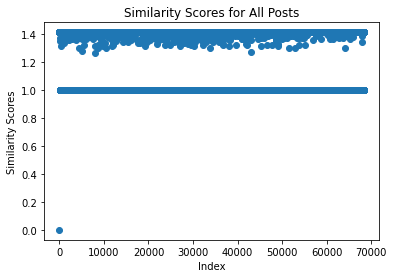

In [19]:
plt.scatter(*zip(*euc_score1))
plt.title("Similarity Scores for All Posts")
plt.xlabel("Index")
plt.ylabel("Similarity Scores")
plt.show()

Remove the location of the first post from our score list because we don't want to recommend a location we already posted

In [20]:
euc_score1 = list(filter(lambda x: x[0] != first_post_index, euc_score1))

Sort our euclidean score list from low to high because we want the closest points

In [21]:
sorted_locations1 = sorted(euc_score1, key = lambda x:x[1], reverse=False)

Print our top 5 recommended locations

In [22]:
print("Top 5: Locations suggested for you: \n")
x1 = []
y1 = []
i = 1
unique_locations1 = set()

for location in sorted_locations1:
    
    index = location[0]
    location_name = cb_df[cb_df.index == index]["location_name"].values
    
    if (i <= 5 and not (location_name[0] in unique_locations1)):
        
        unique_locations1.add(location_name[0])
        x1.append(location_name[0])
        y1.append(location[1])
        print(i,'.',location_name[0])
        i+=1

Top 5: Locations suggested for you: 

1 . 
2 . D.U.M.B.O.
3 . A/D/O
4 . Hong Kong Cultural Centre
5 . AZULIK Tulum


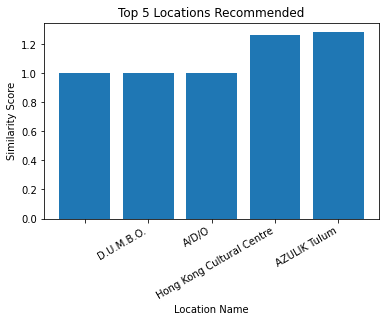

In [23]:
fig, ax = plt.subplots()
ax.bar(x1, y1, linestyle='-')
ax.set_ylabel("Similarity Score")
ax.set_xlabel("Location Name")
ax.set_title("Top 5 Locations Recommended")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.autofmt_xdate()

We can see this model is not too effective when only considering two features, location name and hashtags. Let's see if we can improve this by adding features

### Model 2: Euclidean Distance (Location name + Hashtags + Caption + Accessibility Caption)

We'll add two additional fields to our first model, caption and accessibility Caption

In [11]:
combined_features2 = cb_df["location_name"] + " " + cb_df["hashtags"] + " " + \
                    cb_df["caption"] + " " + cb_df["accessibility_caption"]
print(combined_features2)

0        Mexico thetravellingbeautyqueen, lenkajosefiov...
1        Valley of Fire State Park  Обещала вам пост, к...
2        Edmonds Marina Beach Park  Mia had a great mor...
3        The Rooftop at Pier 17 skatetheskyline ᴛᴀsᴛʏ ᴛ...
4        Donostia-San Sebastián, Spain bss505025, Vivir...
                               ...                        
48588    Concert @ Sea  Golden Earring. Hard. Goed! No ...
48589    Gateway Arch Missouri St. Louis #Missouri No p...
48590    St.Tropez Yacht Port  Port St. Tropez ⚓️ No ph...
48591    Toulouse, France  s u n d a y No photo descrip...
48592    Golden Bee sol, sunny, London, moments #sol #s...
Length: 48593, dtype: object


Use TF-IDF Vectorizer to convert the text data to feature vectors

In [12]:
vectorizer2 = TfidfVectorizer()
feature_vectors2 = vectorizer2.fit_transform(combined_features2)
print(feature_vectors2)

  (0, 159293)	0.07929269527660017
  (0, 123498)	0.07929269527660017
  (0, 124669)	0.016135058550480853
  (0, 83600)	0.07434036400056193
  (0, 150708)	0.07639576718896923
  (0, 83599)	0.06400255648427022
  (0, 82788)	0.07274606942761583
  (0, 48556)	0.0653897436931544
  (0, 93503)	0.03723822559612455
  (0, 55010)	0.03703281955455497
  (0, 105896)	0.04361327226849222
  (0, 14960)	0.038770767807356235
  (0, 70572)	0.03886982941193402
  (0, 33113)	0.05806996383772498
  (0, 181259)	0.0333140346752936
  (0, 126171)	0.030264060670833454
  (0, 98809)	0.04207245990615057
  (0, 72826)	0.03165017975237631
  (0, 112833)	0.02467030213522473
  (0, 55540)	0.05106222937327943
  (0, 41124)	0.04339855716531543
  (0, 84810)	0.15858539055320034
  (0, 92372)	0.14868072800112386
  (0, 113233)	0.03263150925022463
  (0, 151287)	0.037925144999346475
  :	:
  (48589, 153475)	0.24683944233887492
  (48590, 169120)	0.6594016185272257
  (48590, 127880)	0.5093503775951874
  (48590, 184383)	0.28789964725605116
  (4859

In [13]:
euc_dist2 = euclidean_distances(feature_vectors2)
print(euc_dist2)

[[0.         1.41272905 1.38078734 ... 1.4001999  1.41171838 1.41421356]
 [1.41272905 0.         1.41212805 ... 1.41421356 1.41421356 1.41421356]
 [1.38078734 1.41212805 0.         ... 1.41421356 1.41421356 1.41421356]
 ...
 [1.4001999  1.41421356 1.41421356 ... 0.         1.35783728 1.41421356]
 [1.41171838 1.41421356 1.41421356 ... 1.35783728 0.         1.41421356]
 [1.41421356 1.41421356 1.41421356 ... 1.41421356 1.41421356 0.        ]]


In [18]:
euc_score2 = list(enumerate(euc_dist2[first_post_index]))
print(euc_score2[:5]) 

[(0, 0.0), (1, 1.4127290525432554), (2, 1.3807873419278993), (3, 1.3711096847393576), (4, 1.4142135623730951)]


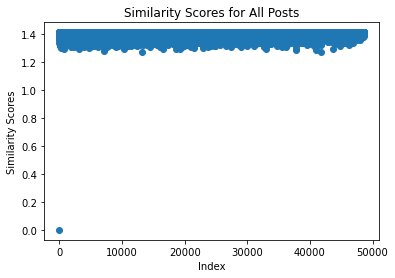

In [19]:
plt.scatter(*zip(*euc_score2))
plt.title("Similarity Scores for All Posts")
plt.xlabel("Index")
plt.ylabel("Similarity Scores")
plt.show()

In [20]:
euc_score2 = list(filter(lambda x: x[0] != first_post_index, euc_score2))

In [21]:
sorted_locations2 = sorted(euc_score2, key = lambda x:x[1], reverse=False)

In [22]:
print("Top 5: Locations suggested for you: \n")
x2 = []
y2 = []
i = 1
unique_locations2 = set()

for location in sorted_locations2:
    
    index = location[0]
    location_name = cb_df[cb_df.index == index]["location_name"].values
    
    if (i <= 5 and not (location_name[0] in unique_locations2)):
        
        unique_locations2.add(location_name[0])
        x2.append(location_name[0])
        y2.append(location[1])
        print(i,'.',location_name[0])
        i+=1

Top 5: Locations suggested for you: 

1 . Mexico City, Mexico
2 . Chichen Itza
3 . Hong Kong Cultural Centre
4 . Playa del Carmen, Quintana Roo
5 . Tulum


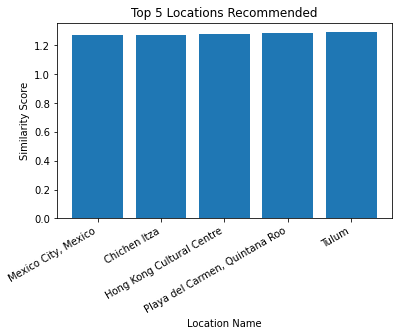

In [23]:
fig, ax = plt.subplots()
ax.bar(x2, y2, linestyle='-')
ax.set_ylabel("Similarity Score")
ax.set_xlabel("Location Name")
ax.set_title("Top 5 Locations Recommended")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.autofmt_xdate()

### Model 3: Cosine Similarity (Location name + Hashtags + Caption + Accessibility Caption)

Find cosine similarity of feature vectors

In [43]:
similarity = cosine_similarity(feature_vectors2)
print(similarity.shape)

(48593, 48593)


In [44]:
print(similarity)

[[1.         0.00209831 0.04671316 ... 0.01972012 0.00352561 0.        ]
 [0.00209831 1.         0.00294718 ... 0.         0.         0.        ]
 [0.04671316 0.00294718 1.         ... 0.         0.         0.        ]
 ...
 [0.01972012 0.         0.         ... 1.         0.07813896 0.        ]
 [0.00352561 0.         0.         ... 0.07813896 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [45]:
similarity_score = list(enumerate(similarity[first_post_index]))

Graph showing the locations and their similarity scores

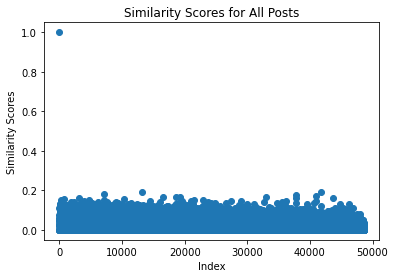

In [46]:
plt.scatter(*zip(*similarity_score))
plt.title("Similarity Scores for All Posts")
plt.xlabel("Index")
plt.ylabel("Similarity Scores")
plt.show()

Remove the location of the first post from our score list because we don't want to recommend a location we already posted

In [47]:
similarity_score = list(filter(lambda x: x[0] != first_post_index, similarity_score))
print(similarity_score[:5])

[(1, 0.0020983120501182452), (2, 0.046713158185843616), (3, 0.06002911620697021), (4, 0.0), (5, 0.029425277123899578)]


Sort our similarity_score array from highest to lowest similarity score

In [48]:
sorted_locations2 = sorted(similarity_score, key = lambda x:x[1], reverse=True)
print(sorted_locations2[:5])

[(41780, 0.19390775723782525), (13221, 0.1908908652423294), (7104, 0.1799708913901848), (37753, 0.1753472477569587), (40959, 0.17164063266394486)]


Show the top 5 recommended locations

In [49]:
print("Top 5: Locations suggested for you: \n")
x2 = []
y2 = []
i = 1
unique_locations2 = set()

for location in sorted_locations2:
    
    index = location[0]
    location_name = cb_df[cb_df.index == index]["location_name"].values
    
    if (i <= 5 and not (location_name[0] in unique_locations2)):
        
        unique_locations2.add(location_name[0])
        x2.append(location_name[0])
        y2.append(location[1])
        print(i,'.',location_name[0])
        i+=1

Top 5: Locations suggested for you: 

1 . Mexico City, Mexico
2 . Chichen Itza
3 . Hong Kong Cultural Centre
4 . Playa del Carmen, Quintana Roo
5 . Tulum


Graph showing the top 5 suggested location and their similarity scores

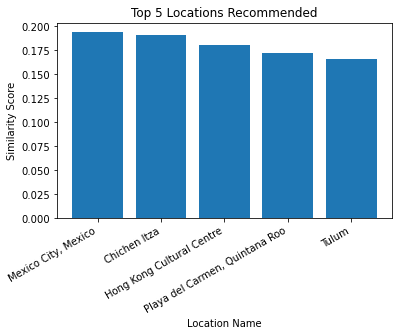

In [50]:
fig, ax = plt.subplots()
ax.bar(x2, y2, linestyle='-')
ax.set_ylabel("Similarity Score")
ax.set_xlabel("Location Name")
ax.set_title("Top 5 Locations Recommended")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.autofmt_xdate()

We observe that we obtain much better recommendations when adding caption and accessibility caption as additional features in our model

### Bonus: Using Custom User Input for Recommendations

Take User Input for a location. We have chosen 'San Diego' as an example

In [51]:
user_input = input('Please input a location: ')

Please input a location: San Diego


Get all the locations

In [52]:
locations_list = cb_df["location_name"].tolist()

Find the closest match to our user inputted location

In [53]:
find_closest_match = difflib.get_close_matches(user_input, locations_list)

In [54]:
close_match = find_closest_match[0]

In [55]:
print(close_match)

San Diego Zoo


Find the index of the closest match

In [56]:
index_close_match = cb_df.index[cb_df["location_name"] == close_match][0]

In [57]:
print(index_close_match)

22197


Get the similarity scores of all the locations to our closest match

In [58]:
similarity_score = list(enumerate(similarity[index_close_match]))

Preview first 5 scores

In [59]:
print(similarity_score[:5])

[(0, 0.03121050919876367), (1, 0.0), (2, 0.025054280224996683), (3, 0.04574268354183754), (4, 0.011913001342339214)]


In [60]:
len(similarity_score)

48593

Graph showing the locations and their similarity scores

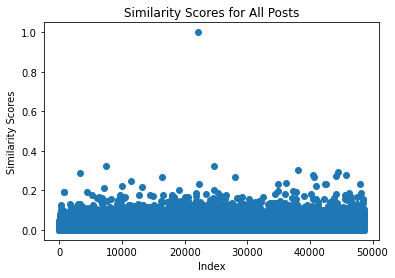

In [61]:
plt.scatter(*zip(*similarity_score))
plt.title("Similarity Scores for All Posts")
plt.xlabel("Index")
plt.ylabel("Similarity Scores")
plt.show()

Sort our similarity_score array from highest to lowest similarity score

In [62]:
sorted_locations = sorted(similarity_score, key = lambda x:x[1], reverse=True)

Preview first 5

In [63]:
print(sorted_locations[:5])

[(22197, 1.0), (7480, 0.32252091782776493), (24640, 0.32100653884931374), (38070, 0.30502062024682147), (44522, 0.29321165691260026)]


Show the top 5 recommended locations

In [64]:
print("Top 5: Locations suggested for you: \n")
x3 = []
y3 = []
i = 1
for location in sorted_locations:
    index = location[0]
    location_name = cb_df[cb_df.index == index]["location_name"].values
    if (i <= 5):
        x3.append(location_name[0])
        y3.append(location[1])
        print(i,'.',location_name[0])
        i+=1

Top 5: Locations suggested for you: 

1 . San Diego Zoo
2 . Sunset Cliffs, San Diego
3 . Blue Mountains National Park
4 . Normal Heights, San Diego
5 . Pacific Beach, San Diego


Graph showing the top 5 suggested location and their similarity scores

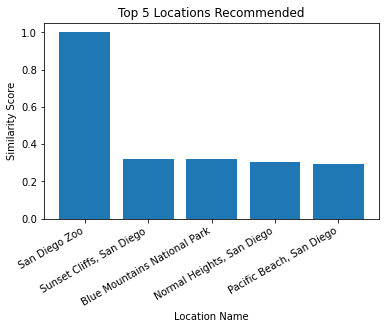

In [65]:
fig, ax = plt.subplots()
ax.bar(x3, y3, linestyle='-')
ax.set_ylabel("Similarity Score")
ax.set_xlabel("Location Name")
ax.set_title("Top 5 Locations Recommended")
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
fig.autofmt_xdate()

## 5. Latent Factor Models

In this section, we are going to experiment training our data with PySpark's ALS algorithm using different factors to build the ratings and parameters to optimize our model.

Below are helper functions to build and train the model.

In [66]:
def evaluate(model, data, labelCol):
    predictions = model.transform(data)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol=labelCol,
                                predictionCol="prediction")
    return evaluator.evaluate(predictions)

def flatten_(v):
    try:
        return float(v[0])
    except ValueError:
        return None

flatten = udf(flatten_, DoubleType())

tst_rmse = []

### Model 1

In Model 1, we will count the number of occurrences for each pair of <code>owner_id</code> and <code>location_id</code>. This count will be considered as our ratings.

In [67]:
LF_df = df.select("owner_id", "location_id")
LF_df = LF_df.withColumn("owner_id", col("owner_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType())).\
    withColumnRenamed("owner_id", "user_id")

In [68]:
LF1 = LF_df.groupby("user_id", "location_id").count()

We will use a 80/20 split to train and test our data with the following ALS parameters:
* <code>maxIter</code> = 5
* <code>regParam</code> = 0.01
* <code>rank</code> = 25

In [69]:
(training, test) = LF1.randomSplit([0.8, 0.2], seed=SEED)

als = ALS(maxIter=5, regParam=0.01, rank=25, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="count").setSeed(SEED)
model = als.fit(training)

test_rmse = evaluate(model, test, "count")

tst_rmse.append(test_rmse)

print("Root mean squared error: ", test_rmse)

Root mean squared error:  1.7561659640983387


### Model 2

In Model 2, we will also include the count of the number of occurrences for each pair of <code>tagged_user_id</code> and <code>location_id</code> as in our ratings.

In [70]:
tagged_df = df.select(explode(df.tagged_users_id).alias("user_id"),"location_id")
tagged_df = tagged_df.withColumn("user_id", col("user_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType()))

In [71]:
LF2 = LF_df.union(tagged_df)

In [72]:
LF2 = LF2.groupby("user_id", "location_id").count()

We are going the use the same split and parameters as Model 1.

In [73]:
(training, test) = LF2.randomSplit([0.8, 0.2], seed=SEED)

als = ALS(maxIter=5, regParam=0.01, rank=25, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="count").setSeed(SEED)
model = als.fit(training)

test_rmse = evaluate(model, test, "count")

tst_rmse.append(test_rmse)

print("Root mean squared error: ", test_rmse)

Root mean squared error:  1.3162391951559245


As shown above, we were able to minimize the RMSE of recommendations obtained through model 2.

### Model 3

In Model 3, we will try to sum the number of likes for each <code>location_id</code> and add it as a bias to our ratings.

We will then rescale our ratings to a range between 0 and 5 using MinMaxScaler.

In [74]:
LF_df = df.select("owner_id", "location_id", "location_name", "likes_count")
LF_df = LF_df.withColumn("owner_id", col("owner_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType())).\
    withColumnRenamed("owner_id", "user_id")

In [75]:
tagged_df = df.select(explode(df.tagged_users_id).alias("user_id"),"location_id", "location_name", "likes_count")
tagged_df = tagged_df.withColumn("user_id", col("user_id").cast(IntegerType())).\
    withColumn("location_id", col("location_id").cast(IntegerType()))

In [76]:
LF3_df = LF_df.union(tagged_df)

In [77]:
LF3 = LF3_df.groupby("user_id", "location_id").agg(count('*').alias("count"),\
                                                sum(LF3_df.likes_count).\
                                                alias("sum_likes"))

In [78]:
LF3 = LF3.withColumn("bias_count", col("count") + col("sum_likes"))

To be able to rescale our ratings we first need to convert our dataframe's columns into vectors.

In [79]:
assembler = VectorAssembler(inputCols=["bias_count"], outputCol="bias_count_vec")

LF3 = assembler.transform(LF3)

We can now rescale our ratings to [0,5].

In [80]:
(training, test) = LF3.randomSplit([0.8, 0.2], seed=SEED)

scaler = MinMaxScaler(min=0.0, max=5.0, inputCol="bias_count_vec", outputCol="norm_count")

model = scaler.fit(training)

In [81]:
training = model.transform(training)
test = model.transform(test)

After rescaling, we need to convert the vectors back to their original form.

In [82]:
training = training.withColumn("norm_count", flatten("norm_count"))
test = test.withColumn("norm_count", flatten("norm_count"))

We will still use a 80/20 split along with the same parameters as the previous models to train model 3.

In [83]:
als = ALS(maxIter=5, regParam=0.01, rank=25, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="norm_count").setSeed(SEED)
model = als.fit(training)

test_rmse = evaluate(model, test, "norm_count")

tst_rmse.append(test_rmse)

print("Root mean squared error: ", test_rmse)

Root mean squared error:  0.10247026344760263


As we can see, rescaling our ratings has greatly improved our model's performance.

### Model 4

Now that we know that rescaling our ratings helps our model to converge faster, we will keep the same approach to process our ratings.

In Model 4, we will focus more on tuning our model's parameters using TrainValidationSplit.

Rescaling rating to range [0,5]

In [84]:
(training, test) = LF3.randomSplit([0.8, 0.2], seed=SEED)

scaler = MinMaxScaler(min=0.0, max=5.0, inputCol="bias_count_vec", outputCol="norm_count")

scaler_model = scaler.fit(training)

In [85]:
training = scaler_model.transform(training)
test = scaler_model.transform(test)

Flatten Columns

In [86]:
training = training.withColumn("norm_count", flatten("norm_count"))
test = test.withColumn("norm_count", flatten("norm_count"))

With the following parameters, TrainValidationSplit will be able to generate 8 submodels to determine the best model.

In [87]:
regParams = [0.01, 0.1]
iterations = [5, 10]
ranks = [50, 70]

We will split our data into 60% Training, 20% Validation and 20% Testing.

We will also set <code>collectSubModels</code> to <code>True</code> to collect all submodels created.

In [88]:
als = ALS(coldStartStrategy="drop",userCol="user_id", itemCol="location_id", ratingCol="norm_count").setSeed(SEED)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="norm_count", predictionCol="prediction")

paramGrid = ParamGridBuilder()\
    .addGrid(als.regParam, regParams) \
    .addGrid(als.maxIter, iterations)\
    .addGrid(als.rank, ranks)\
    .build()


tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.75,
                           collectSubModels=True,
                           seed = SEED)

model = tvs.fit(training)

best_model = model.bestModel

test_rmse = evaluate(best_model, test, "norm_count")

tst_rmse.append(test_rmse)

print("Root mean squared error: ", test_rmse)

Root mean squared error:  0.08953709474024797


Let's now plot the validation metrics of TrainValidationSplit

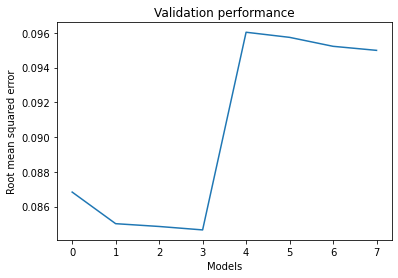

In [89]:
plt.plot(model.validationMetrics)
plt.title("Validation performance")
plt.xlabel("Models")
plt.ylabel("Root mean squared error")
plt.show()

From the above graph, we can conclude that submodel at index 3 is the best model with the following parameters:

In [90]:
assert best_model._java_obj.parent().getRegParam() == model.subModels[3]._java_obj.parent().getRegParam()
assert best_model._java_obj.parent().getMaxIter() == model.subModels[3]._java_obj.parent().getMaxIter()
assert best_model._java_obj.parent().getRank() == model.subModels[3]._java_obj.parent().getRank()

print("regParam: ", best_model._java_obj.parent().getRegParam())
print("maxIter: ", best_model._java_obj.parent().getMaxIter())
print("Rank: ", best_model._java_obj.parent().getRank())

regParam:  0.01
maxIter:  10
Rank:  70


Now that we were able to choose a set of optimal hyperparameters for ALS. Can we still do better?

### Model 5

In Model 5, we will try to instead rescale our ratings to a range between 0 and 1 and use the set of optimal parameters found in Model 4.

In [91]:
(training, test) = LF3.randomSplit([0.8, 0.2], seed=SEED)

scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="bias_count_vec", outputCol="norm_count")

scaler_model = scaler.fit(training)

In [92]:
training = scaler_model.transform(training)
test = scaler_model.transform(test)

Flatten Columns

In [93]:
training = training.withColumn("norm_count", flatten("norm_count"))
test = test.withColumn("norm_count", flatten("norm_count"))

In [94]:
als = ALS(maxIter=10, regParam=0.01, rank=70, coldStartStrategy="drop",
          userCol="user_id", itemCol="location_id", ratingCol="norm_count").setSeed(SEED)
model = als.fit(training)

test_rmse = evaluate(model, test, "norm_count")

tst_rmse.append(test_rmse)

print("Root mean squared error: ", test_rmse)

Root mean squared error:  0.0187919115715911


Hooray! We found our best model!

### Model performances on test set

Let's now plot what we have achieved so far after experimenting different factors and parameters.

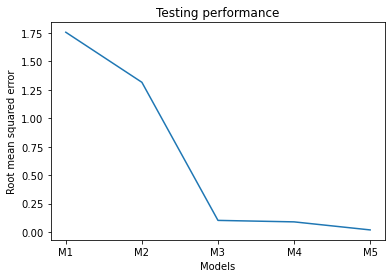

In [95]:
x = ['M1', 'M2', 'M3', 'M4', 'M5']
plt.plot(x, tst_rmse)
plt.title("Testing performance")
plt.xlabel("Models")
plt.ylabel("Root mean squared error")
plt.show()

Indeed after trying different factors and parameters, we can conclude that our model performs the best when we:

   * rescale our ratings to a range between 0 and 1
   * use a set of optimal hyperparameters (regParam = 0.01, maxIter = 10, rank = 70)

### Top 5 recommendation for a specific user using our best model

 Before looking at the recommendation list, let’s have a look at the user's preferences:

In [96]:
LF3_df.select("location_name").filter(col("user_id") == 398526345).limit(5).show()

+--------------------+
|       location_name|
+--------------------+
|              Mexico|
|           Ski Dubai|
|SHAPE Medical Centre|
| Munnar Hill Station|
|    Al Meydan Bridge|
+--------------------+



In [97]:
user = LF3.select(als.getUserCol()).filter(col("user_id") == 398526345).limit(1)
userRec = model.recommendForUserSubset(user, 5)

And here are the Top 5 recommendations from our model:

In [98]:
print("Top 5 locations recommended to user 398526345")
for i, loc in enumerate(userRec.collect()[0]["recommendations"]):
    name = LF3_df.select("location_name").filter(col("location_id") == loc["location_id"]).limit(1).\
                                                                                        collect()[0]["location_name"]
    print(i+1, name)

Top 5 locations recommended to user 398526345
1 Oxford Circus
2 Maui, Hawaii
3 Maui Hawaii
4 Algarve Portugal
5 Yukon
